In [1]:
import braidz_analysis as bz
import numpy as np
import matplotlib.pyplot as plt

2024-12-17 17:14:03,028 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
root_folder = "/home/buchsbaum/mnt/nfc3008/md0/Experiments"
exp_file = ["20241216_123918.braidz"]
exp_data = bz.braidz.read_multiple_braidz(exp_file, root_folder)

2024-12-17 17:14:03,038 [INFO] Processing 1 files
2024-12-17 17:14:03,055 [INFO] Reading /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241216_123918.braidz using pyarrow


Processing file 1/1: /home/buchsbaum/mnt/nfc3008/md0/Experiments/20241216_123918.braidz


2024-12-17 17:14:05,345 [WARNING] PyArrow parsing failed: Empty CSV file:<zipfile.ZipExtFile name='experiment_info.csv' mode='r'>, falling back to pandas
2024-12-17 17:14:05,346 [WARNING] Empty CSV file <zipfile.ZipExtFile name='experiment_info.csv' mode='r'> encountered
2024-12-17 17:14:05,366 [INFO] Combining processed data
2024-12-17 17:14:05,366 [INFO] Combined 1 kalman estimate dataframes
2024-12-17 17:14:05,367 [INFO] Combined 1 stimulus dataframes


In [4]:
stim_data = bz.processing.get_stim_data(exp_data["df"], exp_data["stim"])

In [9]:
stim_data.keys()

dict_keys(['angular_velocity', 'angular_velocity_peak_centered', 'linear_velocity', 'linear_velocity_peak_centered', 'xyz', 'heading_difference', 'heading_difference_peak_centered', 'reaction_delay'])

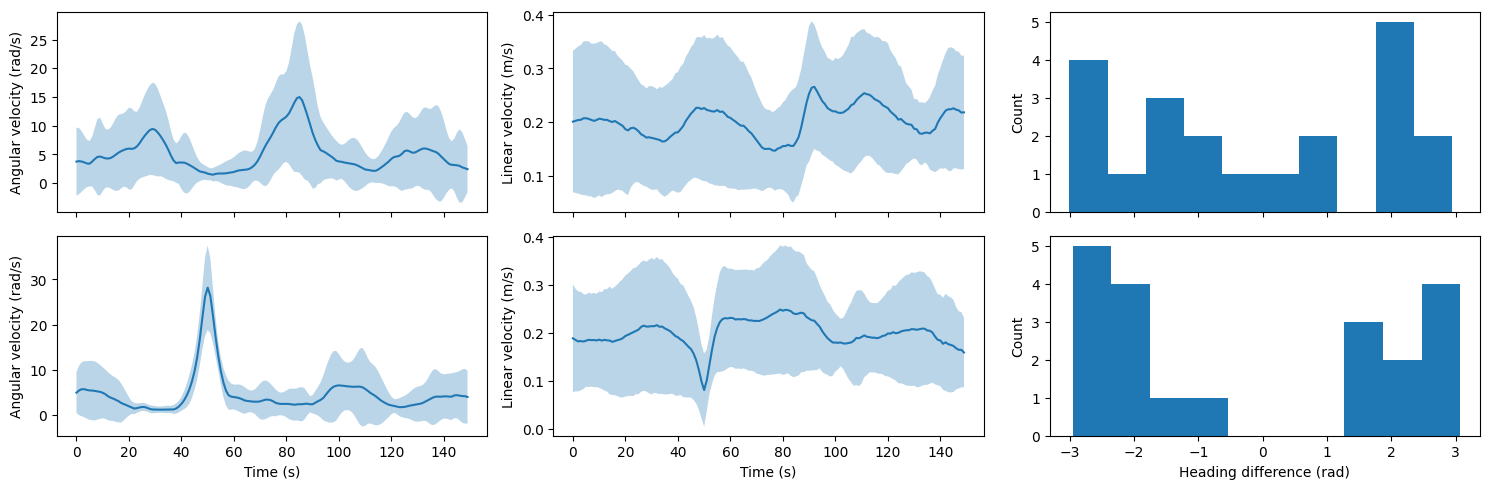

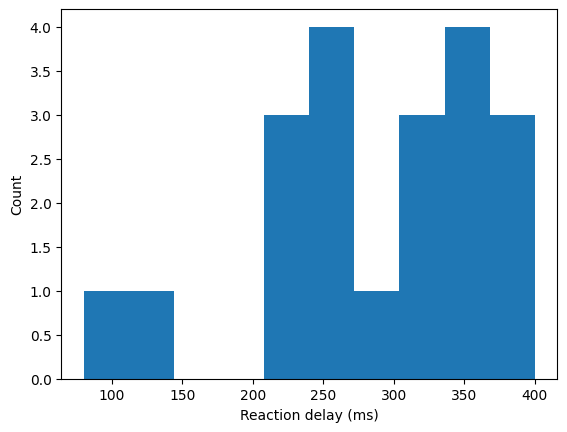

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 5), sharex="col")
bz.plotting.plot_mean_and_std(np.abs(stim_data["angular_velocity"]), ax=axs[0, 0])
bz.plotting.plot_mean_and_std(stim_data["linear_velocity"], ax=axs[0, 1])
bz.plotting.plot_histogram(stim_data["heading_difference"], ax=axs[0, 2])

bz.plotting.plot_mean_and_std(
    np.abs(stim_data["angular_velocity_peak_centered"]), ax=axs[1, 0]
)
bz.plotting.plot_mean_and_std(stim_data["linear_velocity_peak_centered"], ax=axs[1, 1])
bz.plotting.plot_histogram(stim_data["heading_difference_peak_centered"], ax=axs[1, 2])

axs[1, 0].set_xlabel("Time (s)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 2].set_xlabel("Heading difference (rad)")

axs[0, 0].set_ylabel("Angular velocity (rad/s)")
axs[0, 1].set_ylabel("Linear velocity (m/s)")
axs[0, 2].set_ylabel("Count")

axs[1, 0].set_ylabel("Angular velocity (rad/s)")
axs[1, 1].set_ylabel("Linear velocity (m/s)")
axs[1, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

fig = plt.figure()
plt.hist(stim_data["reaction_delay"] * 10)
plt.xlabel("Reaction delay (ms)")
plt.ylabel("Count")
plt.show()

# Understanding the Data Structure

The `combined_data` dictionary contains structured data from braidz files with several key components:

## Key Components
- `df`: Contains the main `kalman_estimates` data (always present)
- `stim`: Contains stimulus-related data (if present)
- `opto`: Contains optogenetics data (if present)

Example of checking available keys:
```
print(f"Available data keys: {list(combined_data.keys())}")
```

## Data Structure
The main DataFrame (`combined_data['df']`) contains various measurements and tracking data. You can examine its structure:

```
# View all columns in the main DataFrame
columns = combined_data['df'].columns
print("Available columns:", columns.tolist())
```

## Working with Groups

The data is organized hierarchically using two main identifiers:
- `obj_id`: Unique identifier for each tracked object (can be the same across different experiments)
- `exp_num`: Experiment number for different recording sessions

### Grouping Patterns

1. Group by object:
```
object_groups = combined_data['df'].groupby('obj_id')
```

2. Group by experiment:
```
experiment_groups = combined_data['df'].groupby('exp_num')
```

3. Group by both (most common use case):
```
# This creates groups for each unique object within each experiment
obj_exp_groups = combined_data['df'].groupby(['obj_id', 'exp_num'])
```